In [1]:
import numpy as np
import nengo
from nengo import Lowpass
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.io
from model import DotPerception, detect_extrema_dot_motion
palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='ticks', rc={'font.size':12, 'mathtext.fontset': 'cm'})

# Model

In [9]:
def build_network(inputs, w_accumulator, w_speed, nActions=2, nNeurons=500, synapse=0.1, seed=0, ramp=1, threshold=0.5, speed=-0.1, relative=0,
        max_rates=nengo.dists.Uniform(60, 80), rA=1, save_w=False, weights_or_decoders="decoders"):
    
    net = nengo.Network(seed=seed)
    net.config[nengo.Connection].synapse = 0.03
    net.config[nengo.Probe].synapse = 0.03
    net.config[nengo.Ensemble].max_rates = max_rates

    # references
    net.inputs = inputs
    net.seed = seed
    net.synapse = synapse
    net.nNeurons = nNeurons

    net.ramp = ramp
    net.threshold = threshold
    net.speed = speed
    net.relative = relative

    func_input = lambda t: net.inputs.sample(t)
    func_threshold = lambda t: net.threshold
    func_speed = lambda t: net.speed
    func_ramp = lambda x: net.synapse * net.ramp * x
    func_value = lambda x: [x[0]-x[1]*net.relative, x[1]-x[0]*net.relative]  # raw evidence vs relative advantage

    ePos = nengo.dists.Choice([[1]])
    iPos = nengo.dists.Uniform(0, 1)

    with net:
        # Inputs
        environment = nengo.Node(func_input)
        baseline_threshold = nengo.Node(func_threshold)
        speed_control = nengo.Node(func_speed)
        # Ensembles
        perception = nengo.Ensemble(nNeurons, nActions, seed=seed)
        accumulator = nengo.Ensemble(nNeurons, nActions, radius=rA, seed=seed)
        value = nengo.Ensemble(nNeurons, nActions, radius=net.threshold, seed=seed)
        boundary = nengo.Ensemble(nNeurons, 1, seed=seed)
        gate = nengo.Ensemble(nNeurons, 1, encoders=ePos, intercepts=iPos, seed=seed)
        action = nengo.networks.EnsembleArray(nNeurons, nActions, encoders=ePos, intercepts=iPos, seed=seed)
        # Connections
        nengo.Connection(environment, perception, seed=seed)  # external inputs
        nengo.Connection(perception, accumulator, synapse=net.synapse, function=func_ramp, seed=seed)  # send percepts to accumulator
        # recurrent cortical connection for accumulation
        if save_w:
            conn_accumulator = nengo.Connection(accumulator, accumulator, synapse=net.synapse, seed=seed)            
        elif weights_or_decoders=="decoders":
            conn_accumulator = nengo.Connection(accumulator.neurons, accumulator, synapse=net.synapse, transform=w_accumulator, seed=seed)
        elif weights_or_decoders=="weights":
            conn_accumulator = nengo.Connection(accumulator.neurons, accumulator.neurons, synapse=net.synapse, transform=w_accumulator, seed=seed)
        nengo.Connection(accumulator, value, function=func_value, seed=seed)  # compute value from evidence in accumulator
        nengo.Connection(value, action.input, seed=seed)
        nengo.Connection(baseline_threshold, gate, seed=seed)  # baseline activity for gate population
        nengo.Connection(speed_control, boundary, seed=seed)  # external inputs (from "cortex") sets decision threshold based on task instructions
        # corticostriatal white matter connection
        if save_w:
            conn_speed = nengo.Connection(boundary, gate, seed=seed)
        elif weights_or_decoders=="decoders":
            conn_speed = nengo.Connection(boundary.neurons, gate, transform=w_speed, seed=seed)
        elif weights_or_decoders=="weights":
            conn_speed = nengo.Connection(boundary.neurons, gate.neurons, transform=w_speed, seed=seed)
        nengo.Connection(gate, action.input, transform=-1*np.ones((nActions, 1)))  # inhibition via decision criteria
        # Probes
        net.pInputs = nengo.Probe(environment, synapse=None)
        net.pPerception = nengo.Probe(perception)
        net.pAccumulator = nengo.Probe(accumulator)
        net.pValue = nengo.Probe(value)
        net.pGate = nengo.Probe(gate)
        net.pAction = nengo.Probe(action.output)
        net.accumulator = accumulator
        net.value = value
        net.boundary = boundary
        net.gate = gate
        net.conn_accumulator = conn_accumulator
        net.conn_speed = conn_speed
    return net

## Age Manipulation

In [23]:
def degrade_weights(net_young, pre_sim, degrade_accumulator, degrade_speed, seed=0, weights_or_decoders="weights"):
    young_accumulator = pre_sim.data[net_young.conn_accumulator].weights  # decoders
    young_speed = pre_sim.data[net_young.conn_speed].weights  # decoders
    old_accumulator = young_accumulator.copy()
    old_speed = young_speed.copy()
    rng = np.random.RandomState(seed=seed)

    if weights_or_decoders=="decoders":
        idx_accumulator = rng.choice(range(old_accumulator.shape[1]), size=int(degrade_accumulator*old_accumulator.shape[1]), replace=False)
        idx_speed = rng.choice(range(old_speed.shape[1]), size=int(degrade_speed*old_speed.shape[1]), replace=False)
        old_accumulator[:,idx_accumulator] = 0
        old_speed[:,idx_speed] = 0

    if weights_or_decoders=="weights":
        e_accumulator = pre_sim.data[net_young.accumulator].encoders
        e_speed = pre_sim.data[net_young.gate].encoders
        w_accumulator = e_accumulator @ young_accumulator
        w_speed = e_speed @ young_speed
        # print(e_accumulator.shape, old_accumulator.shape, w_accumulator.shape)
        flat_accumulator = w_accumulator.ravel().copy()
        flat_speed = w_speed.ravel().copy()
        idx_accumulator = rng.choice(range(flat_accumulator.shape[0]), size=int(degrade_accumulator*flat_accumulator.shape[0]), replace=False)
        idx_speed = rng.choice(range(flat_speed.shape[0]), size=int(degrade_speed*flat_speed.shape[0]), replace=False)
        flat_accumulator[idx_accumulator] = 0
        flat_speed[idx_speed] = 0
        old_accumulator = flat_accumulator.reshape(w_accumulator.shape)
        old_speed = flat_speed.reshape(w_speed.shape)
        # print(np.sum(w_accumulator), np.sum(old_accumulator))
        # print(np.sum(w_speed), np.sum(old_speed))

    return old_accumulator, old_speed

## Simulation loop

In [41]:
def simulate(
        coherence=0.1,
        degrade_accumulator=0.0,
        degrade_speed=0.0,
        weights_or_decoders="decoders",
        emphases=['speed', 'neutral', 'accuracy'],
        emphases_weighting=[0.8, 0.4, 0.2],
        ramp=1.0,
        threshold=0.4,
        speed=-0.3,
        relative=0.0,
        sigma=0.1,
        nActions=2,
        nNeurons=500,
        max_rates=nengo.dists.Uniform(80, 100),
        rA=1.0,
        trials=10,
        perception_seed=0,
        dt=0.001,
        dt_sample=0.03,
        load=False,
        error=('ci', 95),
        estimator=np.median,
        tmax=3,
        name="forstmann_default"):
    
    columns = ['type', 'id', 'emphasis', 'degrade_accumulator', 'degrade_speed', 'trial', 'accuracy', "RT"]
    dfs = []
    for e, emphasis in enumerate(emphases):
        inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
        inputs.create(coherence=coherence)
        S = emphases_weighting[e] * speed
        for trial in range(trials):
            net_young = build_network(inputs, None, None, nActions=nActions, nNeurons=nNeurons, rA=rA, seed=trial,
                                      max_rates=max_rates, ramp=ramp, threshold=threshold, speed=S, relative=relative,
                                      save_w=True, weights_or_decoders=weights_or_decoders)
            sim_young = nengo.Simulator(net_young, progress_bar=False)
            # simulate the "young" network
            choice = None
            while choice==None:
                sim_young.run(dt)
                if np.any(sim_young.data[net_young.pAction][-1,:] > 0.01):
                    choice = np.argmax(sim_young.data[net_young.pAction][-1,:])
                    RT = sim_young.trange()[-1]
                if sim_young.trange()[-1] > tmax:
                    choice = np.argmax(sim_young.data[net_young.pValue][-1,:])
                    RT = sim_young.trange()[-1]
            correct = True if choice==inputs.correct else False
            # print(f"emphasis {emphasis}, trial {trial}, RT {RT}")
            dfs.append(pd.DataFrame([['young model', trial, emphasis, degrade_accumulator, degrade_speed, trial, 100*correct, RT]], columns=columns))

            # fig, ax = plt.subplots()
            # ax.plot(sim_young.trange(), 0.1*sim_young.data[net_young.pInputs], label='inputs')
            # ax.plot(sim_young.trange(), sim_young.data[net_young.pValue], label=f'young {emphasis}')
            # ax.legend()

            # effectively "age" the model from a functional, young model to an impaired "elderly" model
            old_accumulator, old_speed = degrade_weights(net_young, sim_young, degrade_accumulator, degrade_speed, trial, weights_or_decoders)
            net_old = build_network(inputs, old_accumulator, old_speed,
                                    nActions=nActions, nNeurons=nNeurons, rA=rA, seed=trial,
                                    max_rates=max_rates, ramp=ramp, threshold=threshold, speed=S, relative=relative,
                                    save_w=False, weights_or_decoders=weights_or_decoders)
            sim_old = nengo.Simulator(net_old, progress_bar=False)

            # simulate the "old" network
            choice = None
            while choice==None:
                sim_old.run(dt)
                if np.any(sim_old.data[net_old.pAction][-1,:] > 0.01):
                    choice = np.argmax(sim_old.data[net_old.pAction][-1,:])
                    RT = sim_old.trange()[-1]
                if sim_old.trange()[-1] > tmax:
                    choice = np.argmax(sim_old.data[net_old.pValue][-1,:])
                    RT = sim_old.trange()[-1]
            correct = True if choice==inputs.correct else False
            # print(f"emphasis {emphasis}, trial {trial}, RT {RT}")
            dfs.append(pd.DataFrame([['old model', trial, emphasis, degrade_accumulator, degrade_speed, trial, 100*correct, RT]], columns=columns))

            # fig, ax = plt.subplots()
            # ax.plot(sim_old.trange(), 0.1*sim_old.data[net_old.pInputs], label='inputs')
            # ax.plot(sim_old.trange(), sim_old.data[net_old.pValue], label=f'old {emphasis}')
            # ax.legend()
    
    data = pd.concat(dfs, ignore_index=True)
    data.to_pickle(f"data/{name}.pkl")

# Plot

In [34]:
def plot_young_old(simfile):
    combined = pd.read_pickle(f"data/{simfile}.pkl")

    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=((7, 5)))
    sns.barplot(data=combined, x='emphasis', y='RT', hue='type',
                 palette=palette[:2], ax=axes[0])
    sns.barplot(data=combined, x='emphasis', y='accuracy', hue='type',
                 palette=palette[:2], ax=axes[1])
    axes[0].set(xlabel="Emphasis", ylabel="Response Time (s)")
    # axes[0].legend(ncols=2, loc='upper right')
    axes[1].set(xlabel="Emphasis", ylabel="Accuracy (%)", yticks=[0,20,40,60,80,100])
    axes[1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/forstmann_young_old.svg")
    fig.savefig(f"plots/forstmann_young_old.png", dpi=600)

# Empirical

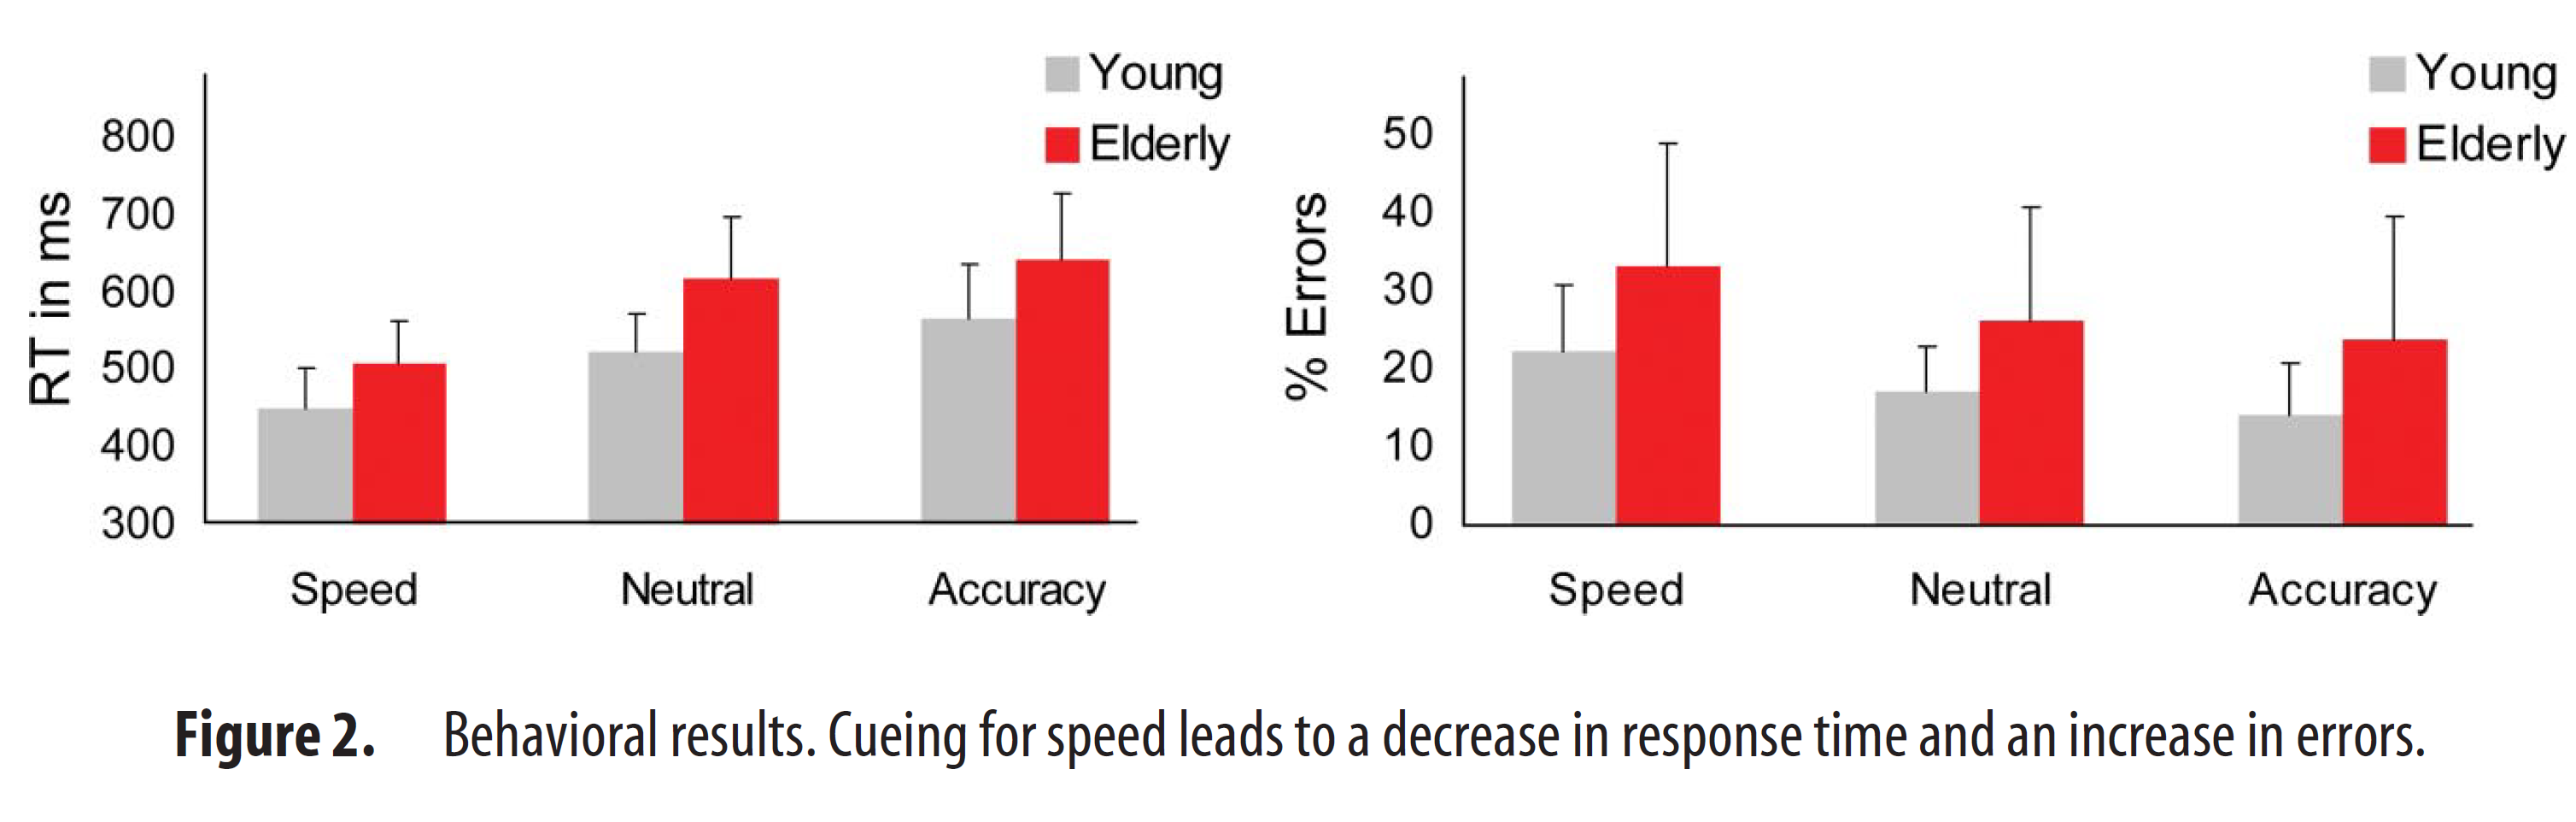

In [35]:
from IPython import display
display.Image("plots/empirical_young_old.png")

# Simulations

C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:624: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


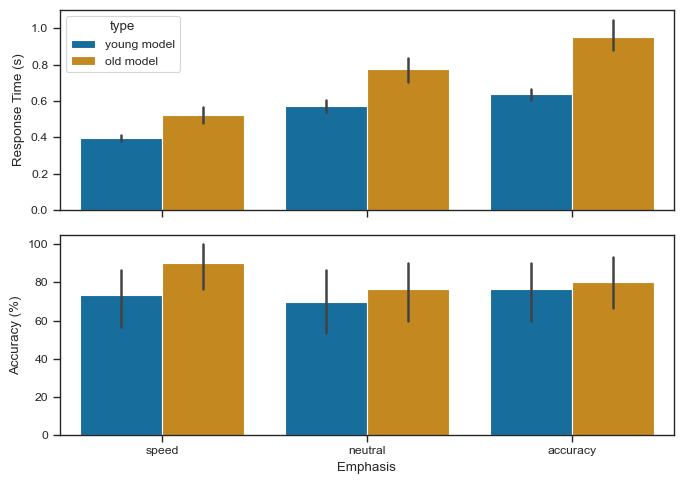

In [44]:
trials = 30
coherence = 0.1
sigma = 0.3
dt_sample = 0.02
emphases_weighting = [0.8, 0.2, 0.0]
emphases = ["speed", "neutral", "accuracy"]
degrade_accumulator = 0.1
degrade_speed = 0.1
threshold = 0.3
speed = -0.15
ramp = 1.5
weights_or_decoders = "weights"

simulate(
    coherence=coherence,
    trials=trials,
    sigma=sigma,
    threshold=threshold,
    ramp=ramp,
    emphases=emphases,
    emphases_weighting=emphases_weighting,
    dt_sample=dt_sample,
    degrade_accumulator=degrade_accumulator,
    degrade_speed=degrade_speed,
    speed=speed,
    weights_or_decoders=weights_or_decoders)

plot_young_old("forstmann_default")